# Wine quality prediction with Random Forests

This follows the analysis from this [blog post](http://www.kdnuggets.com/2016/04/unbalanced-classes-svm-random-forests-python.html).

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import sklearn.cross_validation

Load the wine data set, define a 'good' wine as one which has a quality above 7 and display the head of the dataset.

In [4]:
wine_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")

In [5]:
Y = wine_df.quality.values
wine_df = wine_df.drop('quality', axis = 1)
Y = np.asarray([1 if i >= 7 else 0 for i in Y])

In [6]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4


In [7]:
X = wine_df.as_matrix()

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

Train Random Forests with different number of predictors, using cross validation to get an estimate of the prediction accuracy. Below are the results using both prediction accuracy and F1 score.

In [9]:
scores = []
for val in range(1, 41):
    clf = RandomForestClassifier(n_estimators= val)
    validated = cross_val_score(clf, X, Y, cv = 10)
    scores.append(validated)

In [10]:
clf1 = RandomForestClassifier(n_estimators=2)
validated = cross_val_score(clf1, X, Y, cv = 10)
validated

array([ 0.8757764 ,  0.86956522,  0.81875   ,  0.85625   ,  0.89375   ,
        0.88125   ,  0.84375   ,  0.85534591,  0.83018868,  0.8427673 ])

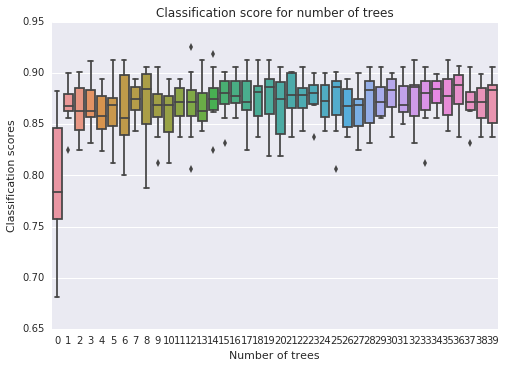

In [11]:
len_y = len(Y)
temp = [i for i in Y if i == 0]
temp_1 = temp.count(0)

percentage = float(temp_1)/float(len_y) * 100

sns.boxplot(data=scores)
plt.xlabel('Number of trees')
plt.ylabel('Classification scores')
plt.title('Classification score for number of trees')
plt.show()


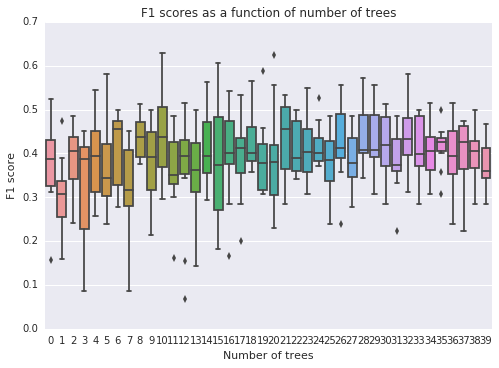

In [12]:
scores = []
for val in range(1, 41):
    clf = RandomForestClassifier(n_estimators= val)
    validated = cross_val_score(clf, X, Y, cv = 10, scoring = "f1")
    scores.append(validated)
    
sns.boxplot(data=scores)
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 scores as a function of number of trees')
plt.show()

Typically deteremine class membership if the predicted probability is above a half.

In [13]:
clf = RandomForestClassifier(n_estimators= 15)
clf.fit(X, Y)
(clf.predict_proba(X)[:, 1] > 0.5).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

Determine the a good cutoff point from prediction probability for class membership 

In [14]:
def cutoff_predict(clf, X, cutoff):
    return (clf.predict_proba(X)[:, 1]> cutoff).astype(int)

def custom_f1(cutoff):
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return sklearn.metrics.f1_score(y, ypred)
    
    return f1_cutoff

In [15]:
scores = []

for cutoff in np.arange(0.1, 0.9, 0.1):
    clf = RandomForestClassifier(n_estimators= 15)
    validated = cross_val_score(clf, X, Y, cv = 10, scoring = custom_f1(cutoff))
    scores.append(validated)

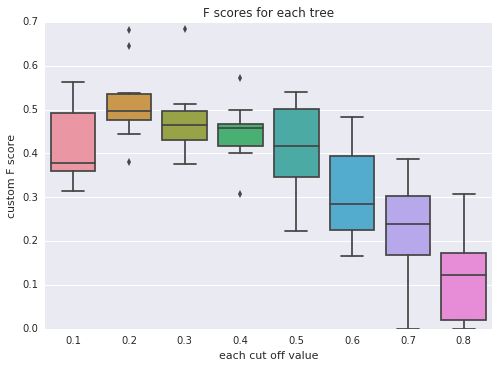

In [16]:
sns.boxplot(y=scores, x = np.arange(0.1, 0.9, 0.1))
plt.title('F scores for each tree')
plt.xlabel('each cut off value')
plt.ylabel('custom F score')
plt.show()

A cutoff abut 0.3 - 0.5 appears to give best predictive performance. Cutoff less than 0.5 as the training set is imbalanced.

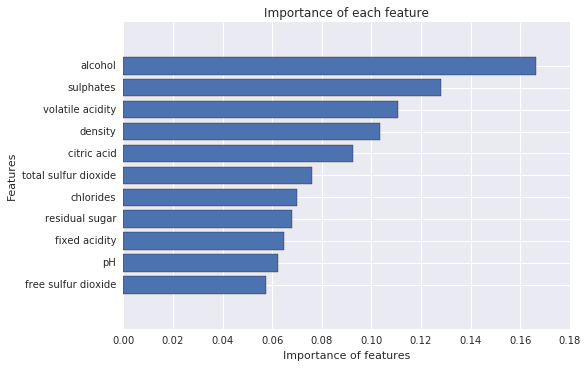

In [17]:
clf = RandomForestClassifier(n_estimators= 15)
clf.fit(X, Y)

imp = clf.feature_importances_
names = wine_df.columns

imp, names = zip(*sorted(zip(imp, names)))

plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature')
plt.show()

Importance in random forests is determined by randomly changing the feature to a value in the data set and measure how the accuracy drops. The feature which if mutated drops the accuracy the most is the most important.

In [18]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm

def plot_decision_surface(clf, X_train, Y_train):
    plot_step = 0.1
    if X_train.shape[1] != 2:
        raise ValueError("X_train should have exactly 2 columns!")
        
    x_min, x_max = X_train[:, 0].min() - plot_step, X_train[:, 0].max() + plot_step
    y_min, y_max = X_train[:, 1].min() - plot_step, X_train[:, 1].max() + plot_step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
    
    clf.fit(X_train, Y_train)
    if hasattr(clf, 'predic_proba'):
        Z = clf.predic_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap = plt.cm.Reds)
    plt.scatter(X_train[:,0], X_train[:, 1], c = Y_train, cmap = plt.cm.Paired)
    plt.show()
    

Plot the decision boundary between the important features and compare with other algorithms.

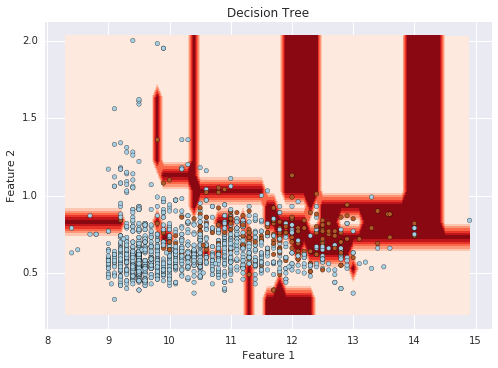

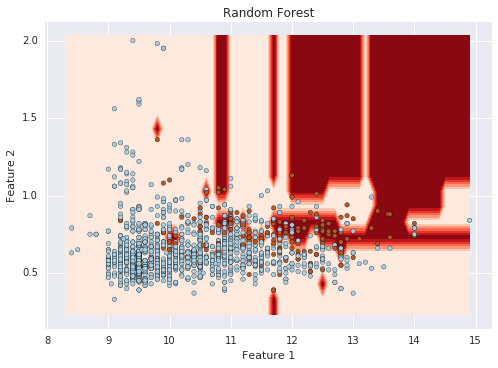

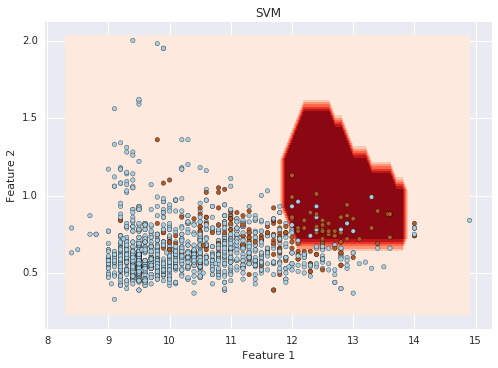

In [19]:
imp_fe = np.argsort(imp)[::-1][0:2]
X_imp = X[:, imp_fe]

algorithms = [DecisionTreeClassifier(), RandomForestClassifier(), sklearn.svm.SVC(C = 100.0, gamma = 1)]
title = ['Decision Tree', 'Random Forest', 'SVM']

for i in xrange(3):
    plt.title(title[i])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plot_decision_surface(algorithms[i], X_imp, Y)


Decision surface for the decision tree and random forest are complex. Random forest is less sensitive, with isolated points having less extreme classification probabilities. SVM has smooth decision boundary. 

In [20]:
svm = [sklearn.svm.SVC(C = 1.0, gamma = 1.0, class_weight = None),
      sklearn.svm.SVC(C = 1.0, gamma = 1.0, class_weight = 'auto')]

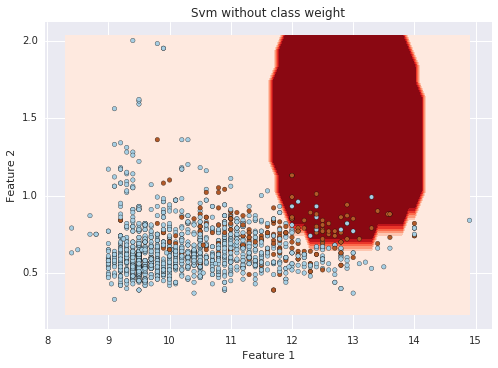

/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


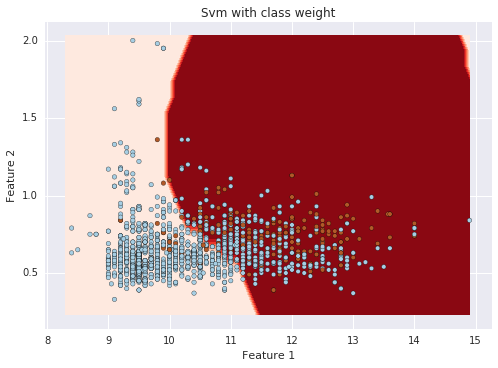

In [21]:
title = ['Svm without class weight', 'Svm with class weight']

for i in xrange(2):
    plt.title(title[i])
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plot_decision_surface(svm[i], X_imp, Y)

The first SVM with equal class weights only classifies a small subset of the positive training points correctly. It produces very few false positives, it has higher overall precision but lower recall, than the second SVM.